# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
# !pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import json 
import matplotlib.pyplot as plt

# %matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/6g/_g42q4cs3fq6bptzbgmmbqb40000gn/T/ipykernel_9255/1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Axes: title={'center': 'Google Search Trends - May 2020'}, xlabel='Date', ylabel='Search Trends'>

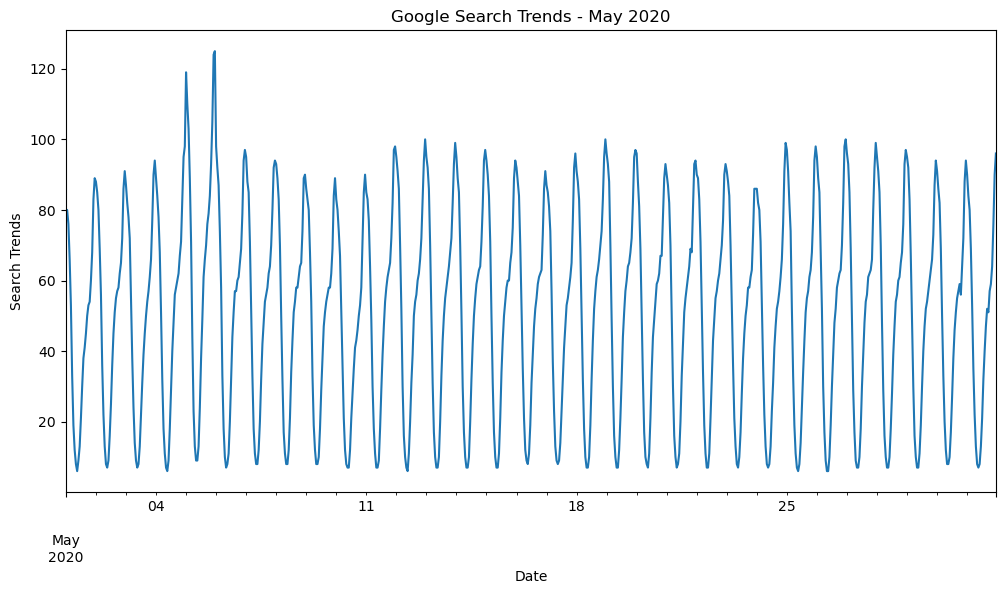

In [5]:
# Slice the DataFrame to just the month of May 2020
may_2020 = df_mercado_trends['2020-05-01':'2020-05-31']

# Plot to visualize the data for May 2020
may_2020['Search Trends'].plot(
    figsize=(12, 6),
    title='Google Search Trends - May 2020',
    ylabel='Search Trends'
    )


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print(f"traffic for May 2020: {traffic_may_2020}")


traffic for May 2020: 38181


In [7]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_traffic = df_mercado_trends.resample('ME')['Search Trends'].sum()

# View the median_monthly_traffic value
median_monthly_traffic = monthly_traffic.median()
print(f"median monthly traffic: {median_monthly_traffic}")

median monthly traffic: 35172.5


1.0855355746677091


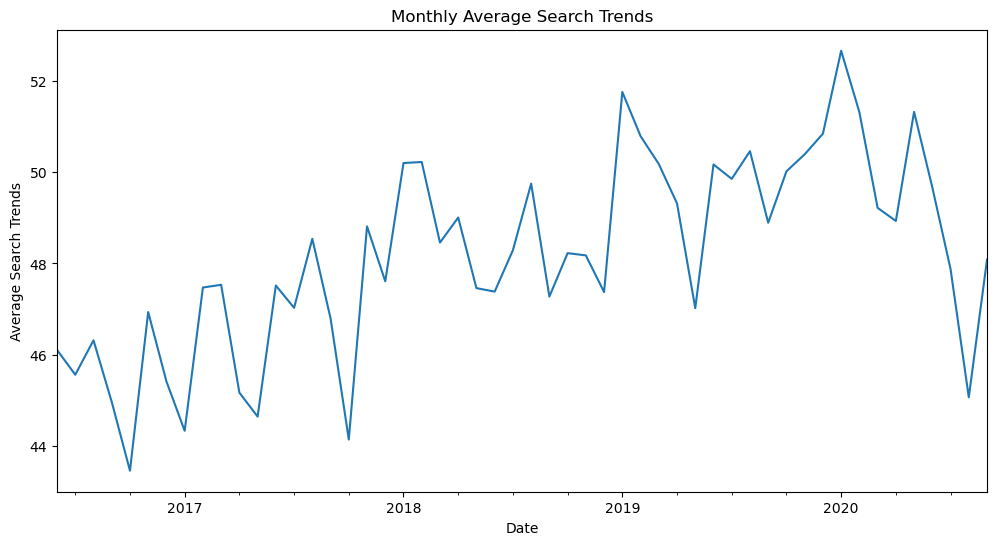

In [8]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
compare_traffic = traffic_may_2020/median_monthly_traffic

monthly_data = df_mercado_trends['Search Trends'].resample('ME').mean()

# Create the plot
monthly_data.plot(
    figsize=(12,6),
    title='Monthly Average Search Trends',
    ylabel='Average Search Trends'
)

print(f"{compare_traffic}")

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, looking at the plot above, we can see that May 2020 shows a notable increase in search traffic compared to surrounding months. The data point for May 2020 shows one of the higher peaks in the time series, reaching approximately 52 on the search trends scale. This aligns with our previous calculation showing that May 2020's traffic was 8.55% higher than the median monthly traffic. This increase in search activity coincides with the month when MercadoLibre released its financial results, suggesting increased public interest in the company during this period.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

<Axes: title={'center': 'Average Search Traffic by Hour'}, xlabel='Date', ylabel='Search Traffic'>

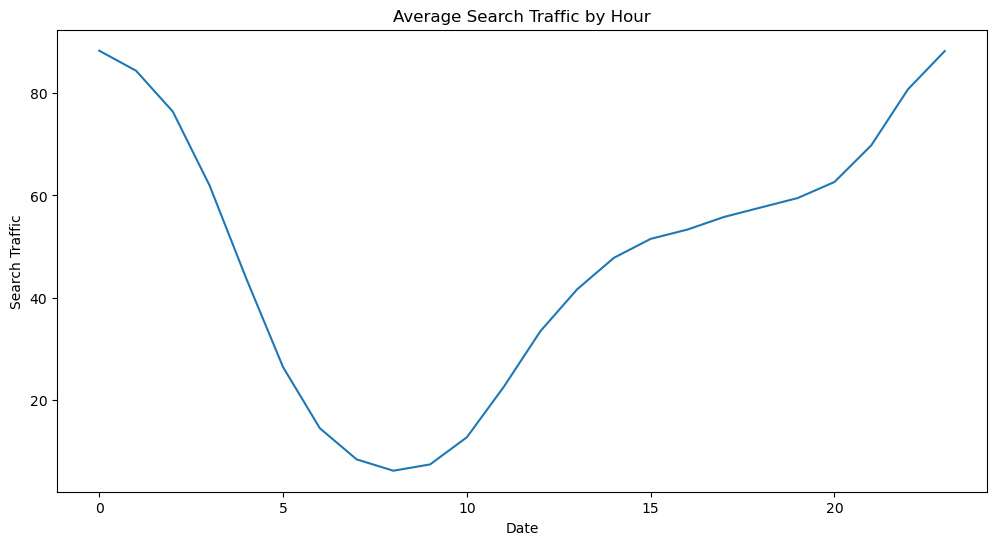

In [9]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
hourly_search = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Create a line plot
hourly_search.plot(
    figsize=(12,6),
    title='Average Search Traffic by Hour',
    ylabel='Search Traffic'
)

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

([<matplotlib.axis.XTick at 0x13e5bf9a0>,
 [Text(1, 0, 'Monday'),
  Text(2, 0, 'Tuesday'),
  Text(3, 0, 'Wednesday'),
  Text(4, 0, 'Thursday'),
  Text(5, 0, 'Friday'),
  Text(6, 0, 'Saturday'),
  Text(7, 0, 'Sunday')])

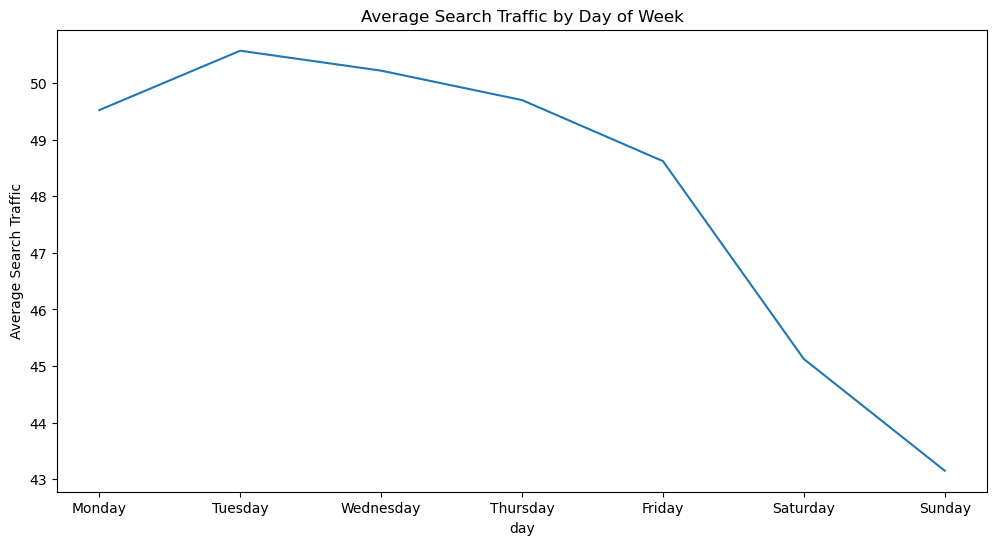

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
weekly_search = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()

# Create a line plot
weekly_search.plot(
    figsize=(12,6),
    title='Average Search Traffic by Day of Week',
    ylabel='Average Search Traffic'
)
plt.xticks(range(1, 8), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

In [11]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_year_search = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Based on the graph showing average search traffic by day of the week, there are clear time-based trends in the data. Search traffic peaks early in the work week, with Tuesday showing the highest average traffic (around 50.5), followed by a gradual decline through the rest of the week. There's a notable drop-off starting Friday and continuing through the weekend, with Sunday showing the lowest search activity (around 43). This pattern suggests that users are most actively searching for MercadoLibre during traditional business days, particularly early in the work week, while engagement significantly decreases during weekends. This insight could be valuable for marketing teams to optimize their campaign timing, focusing their efforts during peak search periods to maximize ROI.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [12]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


<Axes: title={'center': 'MercadoLibre Stock Closing Price'}, xlabel='date', ylabel='closing price ($USD)'>

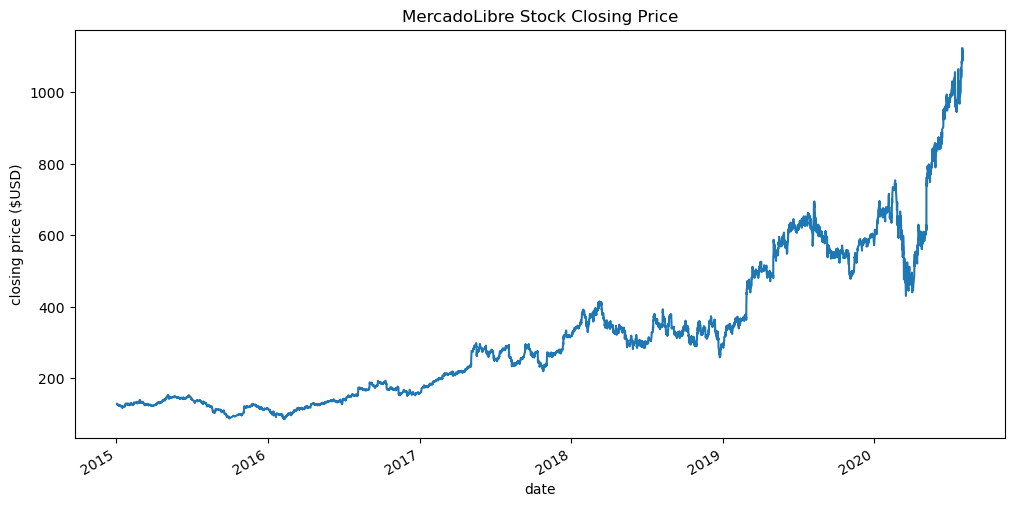

In [13]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].plot(
    figsize=(12,6),
    title="MercadoLibre Stock Closing Price",
    ylabel='closing price ($USD)'
)

In [14]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
mercado_stock_trends_df = pd.concat(
    [df_mercado_stock, df_mercado_trends],
    axis=1
).dropna()

# View the first and last five rows of the DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [15]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = mercado_stock_trends_df['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


array([<Axes: title={'center': 'Stock Close Price'}, ylabel='[Price ($USD), Search Trends]'>,
       <Axes: title={'center': 'Search Trends'}, ylabel='[Price ($USD), Search Trends]'>],
      dtype=object)

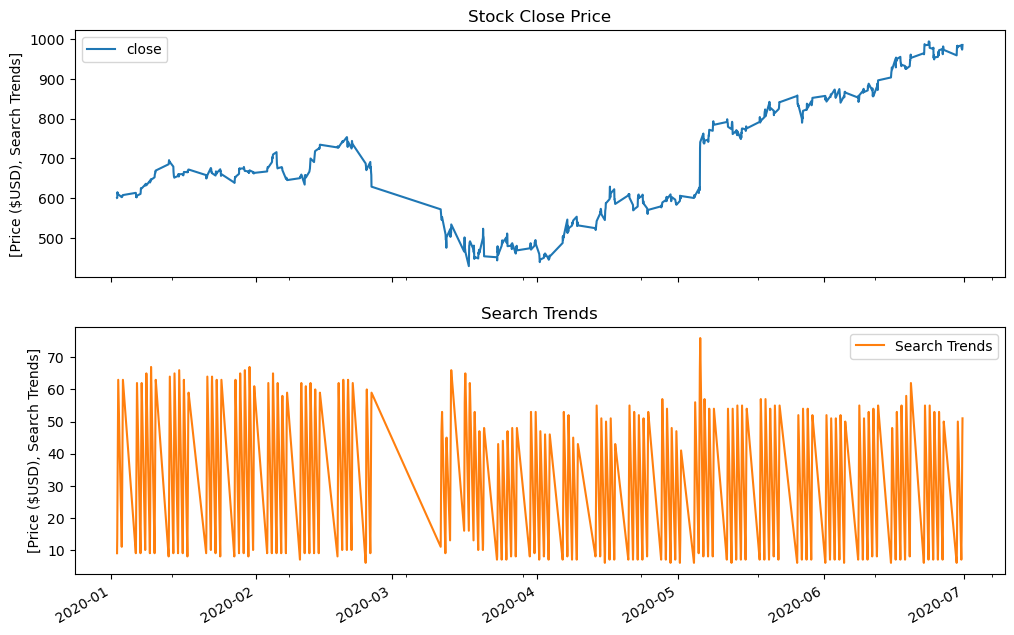

In [16]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
first_half_2020[['close', 'Search Trends']].plot(
    figsize=(12,8),
    subplots=True,
    title=['Stock Close Price', 'Search Trends'],
    ylabel=['Price ($USD)', 'Search Trends']
)

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** The time series data demonstrates MercadoLibre's journey through the market turbulence of early 2020 and its subsequent success. The stock price graph shows a clear narrative: starting stable around $600-700, experiencing a sharp decline to nearly $500 in March during the market shock, then mounting an impressive recovery that saw the stock climb to almost $1000 by June 2020, while the search trends data reveals consistent user engagement patterns with a brief disruption in March that quickly stabilized, collectively illustrating how the company not only survived the initial market shock but thrived in the accelerated shift toward e-commerce platforms.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [17]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)


In [18]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()


<Axes: title={'center': 'Stock Volatility'}, ylabel='Stock Volatility'>

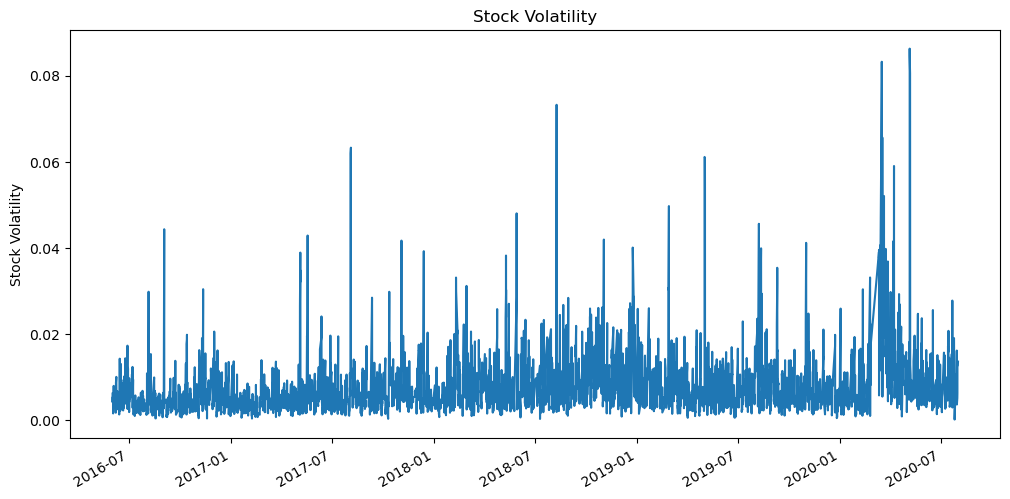

In [19]:
# Visualize the stock volatility
mercado_stock_trends_df['Stock Volatility'].plot(
    figsize=(12,6),
    title='Stock Volatility',
    ylabel='Stock Volatility'
)



**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()

In [21]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())
display(mercado_stock_trends_df.tail())

,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [22]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**  A weak negative correlation (-0.15) between lagged search traffic and stock volatility, and an even weaker positive correlation (0.018) between lagged search traffic and hourly stock returns. These correlation values are too close to zero to suggest any meaningful predictable relationship. In practical terms, this means that search traffic data would not be a reliable predictor of either stock volatility or price returns on an hourly basis.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [23]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = prophet_df.rename(columns={
    'Date':'ds',
    'Search Trends':'y'
})

# Drop an NaN values from the prophet_df DataFrame
prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(prophet_df.head())
display(prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [24]:
# Call the Prophet function, store as an object
model_mercado = Prophet()

In [25]:
# Fit the time-series model.
model_mercado.fit(prophet_df)

01:42:36 - cmdstanpy - INFO - Chain [1] start processing
01:42:42 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model_mercado.make_future_dataframe(
    periods=2000,
    freq='H'
)

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail()

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [27]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model_mercado.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_mercado_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,81.648786,98.428096,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.609068,93.762536,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,67.195231,84.265367,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.747431,69.043137,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,34.309203,51.785006,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


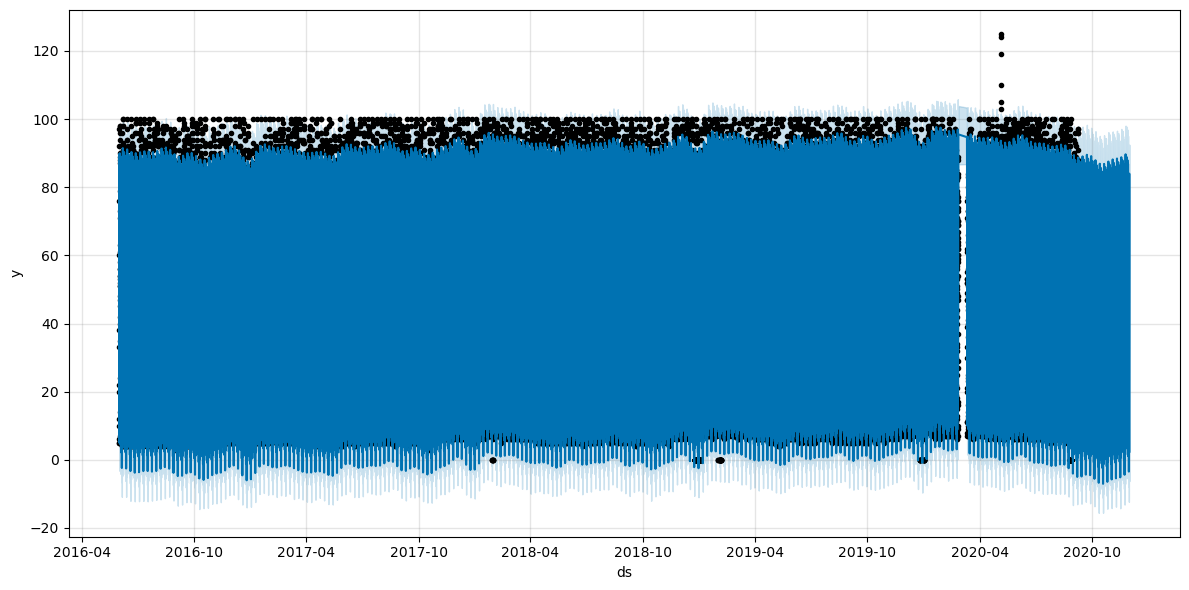

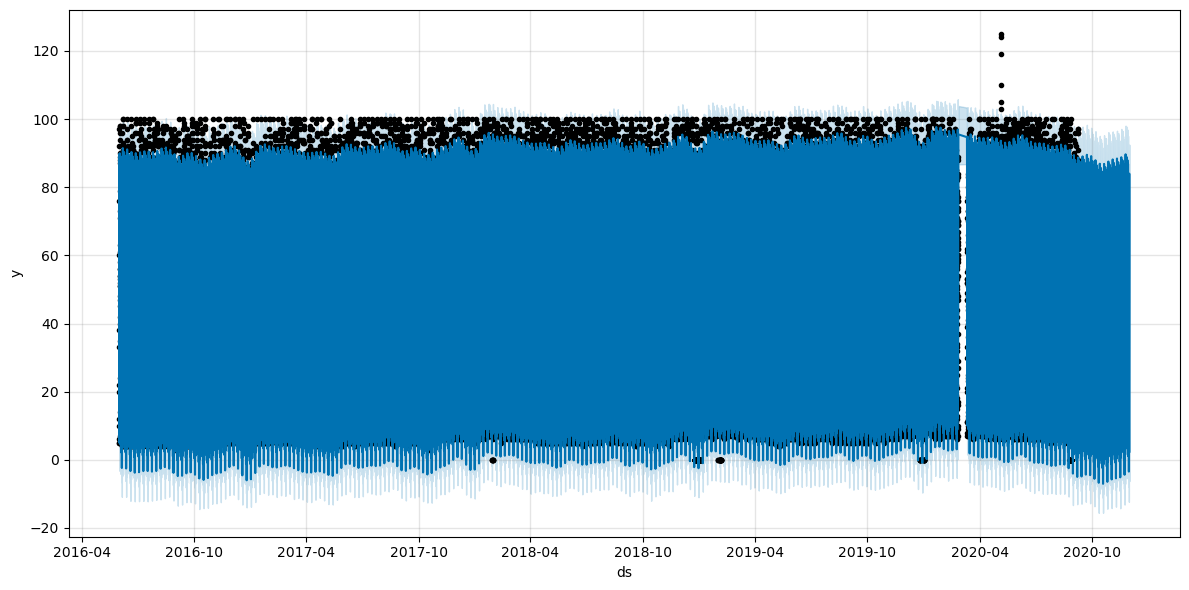

In [28]:
# Plot the Prophet predictions for the Mercado trends data
model_mercado.plot(forecast_mercado_trends, figsize=(12,6))


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Based on the Prophet forecast graphs, the near-term forecast for MercadoLibre's popularity shows a relatively stable trend with a slight downward trajectory into late 2020. The model predicts search traffic will maintain levels between 80-100 units, with wider confidence intervals (shown by the light blue shading) indicating increased uncertainty in the forecast. While there's a notable spike in volatility around early 2020 (likely corresponding to the pandemic period we analyzed earlier), the forecast suggests search interest will stabilize but remain slightly lower than historical averages. The wider prediction intervals in the forecast period also suggest increased uncertainty in future search traffic patterns, though the overall trend remains within the established historical range of search activity.

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [29]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
display(forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head())


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,81.648786,98.428096
2016-06-01 01:00:00,86.005386,77.609068,93.762536
2016-06-01 02:00:00,75.682942,67.195231,84.265367
2016-06-01 03:00:00,60.416789,51.747431,69.043137
2016-06-01 04:00:00,43.302997,34.309203,51.785006


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

Text(0, 0.5, '')

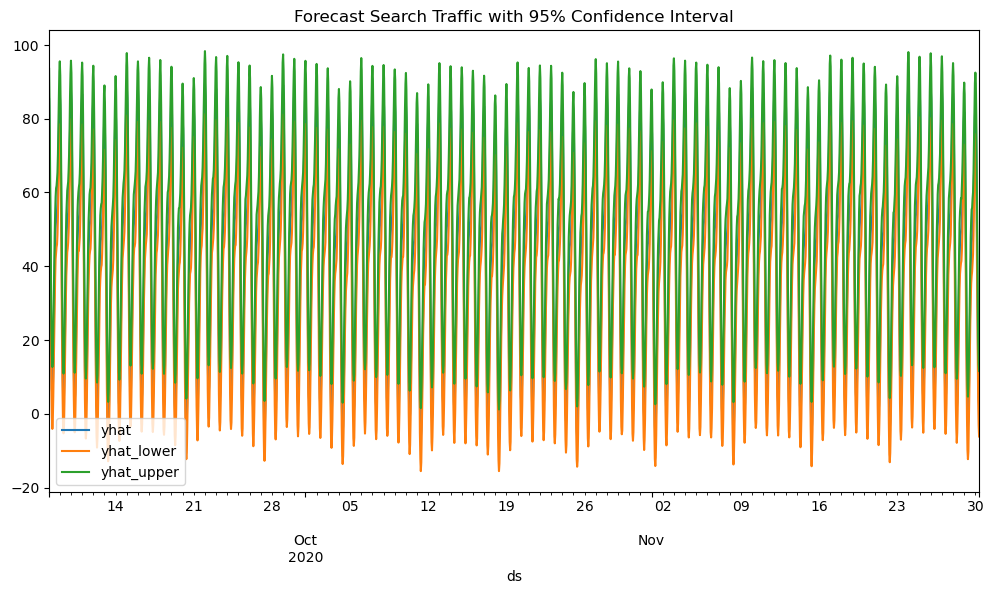

In [30]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
last_2000_hours = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000)

last_2000_hours.plot(
    figsize=(12,6),
    title='Forecast Search Traffic with 95% Confidence Interval'
)
plt.xlabel('ds')
plt.ylabel('')

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

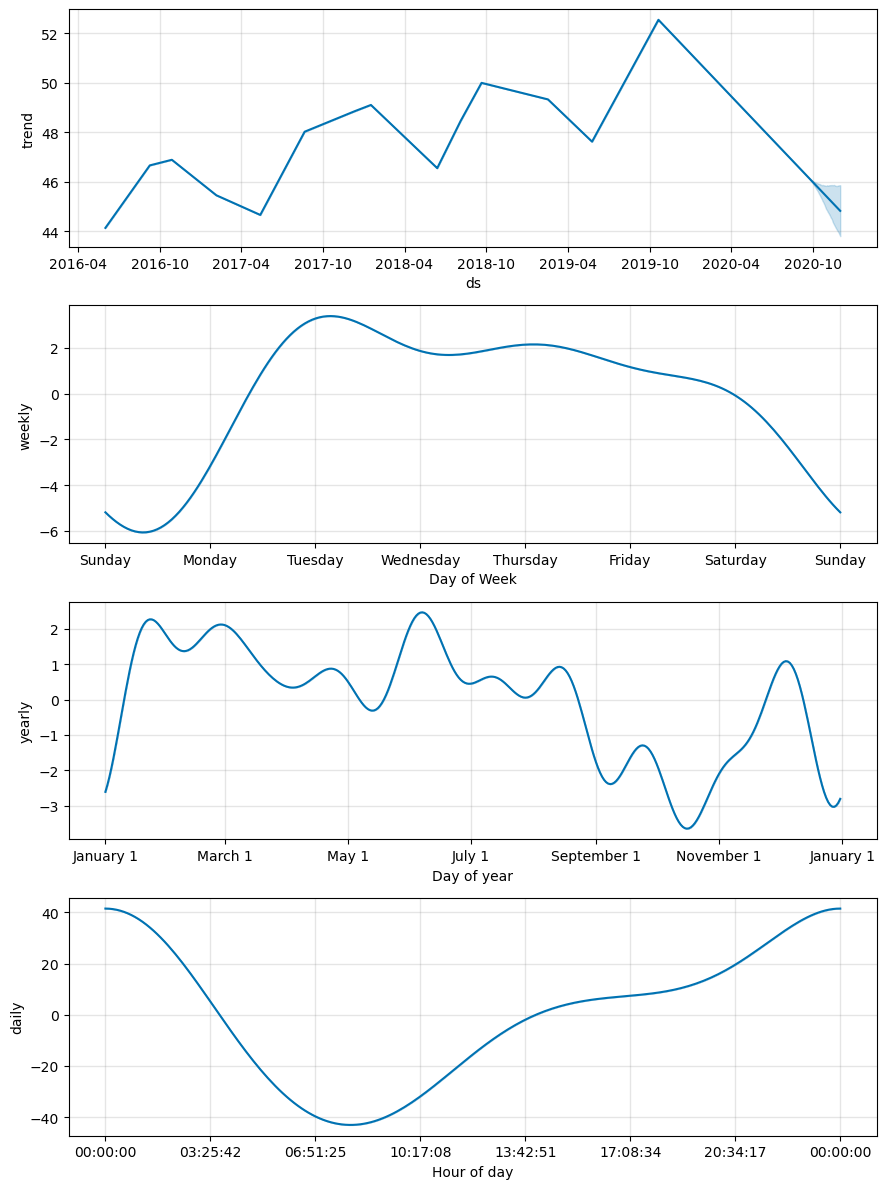

In [31]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
fig = model_mercado.plot_components(forecast_mercado_trends)
plt.show()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Based on the daily pattern shown in the Prophet components plot, search traffic peaks at around midnight (00:00) and maintains high levels until about 1 AM. After this, there's a steady decline through the early morning hours, reaching its lowest point around 5 AM.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** According to the weekly pattern in the Prophet components analysis, Tuesday shows the highest search traffic volume, with a clear peak above other weekdays. This aligns with our earlier analysis of the weekly trends.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** What's the lowest point for search traffic in the calendar year?
Looking at the yearly seasonality component from Prophet, the search traffic reaches its lowest point during October, showing a significant dip in the annual cycle. The traffic gradually increases after this period as it moves into the winter months.
